# DSM 1128
## 主題: 【鐵達尼號生存預測】<br>

關鍵字: #**探索性數據分析(Exploratory Data Analysis)** #**特徵工程(Feature Engineering)** #隨機森林(Random Forest)

Reference: https://colab.research.google.com/github/AI-FREE-Team/Data-Analytics-in-Practice-Titanic/blob/master/Data%20Analytics%20in%20Practice%20-%20Titanic%20Survival%20Prediction.ipynb?hl=zh-tw


鐵達尼號資料集（Titanic dataset）是 Kaggle 上非常知名且常用的入門資料集之一，適用於機器學習模型的分類問題。資料集的目的是預測鐵達尼號船難中哪些乘客能夠生還，哪些乘客不幸遇難。

### 資料集概覽
資料集包含了鐵達尼號上乘客的相關資料，這些資料包括他們的基本信息、船艙等級、票價、登船港口等。這些資訊將被用來預測每個乘客是否生還。

### 資料集欄位說明
1. **PassengerId**: 每個乘客的唯一標識符。
2. **Pclass**: 乘客的艙等（1、2、3），對應於頭等艙、二等艙和三等艙。
3. **Name**: 乘客的姓名。
4. **Sex**: 乘客的性別（male/female）。
5. **Age**: 乘客的年齡。缺失值需要處理。
6. **SibSp**: 乘客在船上的兄弟姐妹/配偶數量。
7. **Parch**: 乘客在船上的父母/子女數量。
8. **Ticket**: 乘客的票號。
9. **Fare**: 乘客支付的票價。
10. **Cabin**: 乘客的艙房號碼。這個欄位有很多缺失值。
11. **Embarked**: 乘客的登船港口，C = Cherbourg, Q = Queenstown, S = Southampton。
12. **Survived**: 目標變數，表示乘客是否生還，1 代表生還，0 代表遇難。

### 目標
利用訓練集中的乘客資料，建立一個分類模型來預測乘客是否會在鐵達尼號船難中生還。今天我們使用*隨機森林*來進行這個分類任務。

### 預處理步驟
1. **處理缺失值**: 如 Age 和 Cabin 等欄位可能會有缺失值，需要進行處理。Age 可以使用中位數填補，Cabin 可以標記為缺失或進行其他填補。
2. **編碼類別變數**: 如 Sex 和 Embarked 需要進行數字化編碼，通常使用 LabelEncoder 或 OneHotEncoding。
3. **特徵縮放**: 如 Fare 和 Age 可能需要進行縮放，以便適應模型的訓練。

### 模型訓練
使用像是 **隨機森林**（Random Forest）、**邏輯回歸**（Logistic Regression）等方法來預測乘客的生還情況。這些模型的性能通常會通過交叉驗證來評估。

### 評價指標
通常使用 **Accuracy**（準確率）來評估模型的預測效果，特別是當樣本不平衡時，也可能會使用 **F1-Score** 或 **AUC** 來衡量模型在預測生還和遇難的準確度。

In [2]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' )

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import warnings
warnings.filterwarnings( 'ignore' )

import os

In [3]:
# from google.colab import files

# uploaded = files.upload()

## 1. 資料蒐集

### 1.1下載鐵達尼號資料集。
從kaggel下載鐵達尼號資料集，共有gender_submission.csv, test.csv, train.csv 三份檔案，並解壓縮後上傳至colab或存放在本地端。
Link: https://www.kaggle.com/c/titanic/data



In [4]:
import pandas as pd
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.2 自定義function，查看資料型態
### function在做甚麼?
在程式設計中，**function**（函式）是一段可以重複使用的程式碼，它執行某個特定的任務或計算。你可以把它想像成一個「黑盒子」(我自己理解成一台機器)，你給它一些「輸入」，然後它會回傳一個「輸出」。就像是你給一個機器不同的麵粉，它會加工後產出不同種類的麵包。

簡單來說，函式可以做以下幾件事：

1. **執行特定任務**：例如，計算兩個數字的和，或是顯示一個訊息。
2. **接受輸入（參數）**：函式可以接收資料，這些資料就像是你給它的「工具」或「材料」。
3. **回傳結果**：函式運行完後，通常會有結果（像是計算的數字或處理過的資料），並回傳給你，讓你可以在程式其他地方使用。

### 比方說：
假設你有一個函式叫做 `addNumbers`，它會計算兩個數字的和：
```python
def addNumbers(a, b):
    return a + b
```
這個函式做的事就是把兩個數字 `a` 和 `b` 相加，然後回傳結果。當你執行這個函式時，你會給它兩個數字，像是 `addNumbers(3, 5)`，它會回傳 `8`。

總結來說，函式讓你能把常常使用的程式碼封裝起來，只要你需要它，就可以簡單地呼叫一次，而不必每次都重新寫一樣的程式碼！

In [5]:
# 定義判別欄位型態的函數
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()   # 判別每個欄位的型態
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True )
    return Column_Types

In [6]:
display( Col_Types(df_train) )

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


## 2. 資料預處理
### 2.1 遺失值(Missing Values)  
上一個專案我們有提到，在進行模型訓練跟資料分析之前，我先檢視資料是否存有遺失值(Missing Values)，如果欄位存有遺失值，之後在特徵工程(Feature Engineering)的過程中，我們可視欄位中遺失值的比例或對預測值的相關性，決定填補或排除此欄位的處理方法。

In [7]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) :
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True )

    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

In [8]:
print( 'train :' )
display( Missing_Counts(df_train) )

print( 'test :' )
display( Missing_Counts(df_test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


這邊可以觀察到Age, Cabin, Embarked, Fare欄位存有缺漏值，後續需要進行填補的處理方法。

### 2.2 基礎統計量(Statistic)

利用 describe( ) 函數，我們可得到每個數值型態欄位的統計量，其用意是為往後我們在觀察欄位是否存有離群值(Outlier)時，作為一個判斷的參考依據，另外，也可用來觀察每個欄位的尺度(scale)是否相似，在餵資料進入模型訓練之前，決定是否需進行資料的正規化(Normalization)或標準化(Standardization)。

In [9]:
# print( 'train' )
display( df_train.describe() )

# print( 'test' )
display( df_test.describe() )

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 3. 資料分析(Data Analysis)

在大致瞭解資料的基本態樣後，我們便可開始對資料做一些關聯性分析。由於是對整體資料進行分析，因此我們先使用concat( )函數將train, test資料集合併，再進行分析。



In [10]:
import seaborn as sns
import pandas as pd

# 合併 train 及 test 的資料
df_data = pd.concat([df_train, df_test], ignore_index=True)

# #合併train及test的資料
# df_data = df_train.append( df_test )
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 3.1 生還者的比率(Survival Ratio)   

首先，我們分析生還者與罹難者的比例是否有明顯極大的落差，比如生還者的比例僅有 1%，若資料有極大的落差時，表示存在『數據不平衡』(Imbalanced Data)的問題，則後續需用特別的方法對資料進行抽樣。利用 value_counts( ) 函數，我們可以計算欄位中各相異類別的數量，船難中的生還者約佔全體乘客的 38.38%、罹難者約佔 61.62%。

In [11]:
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


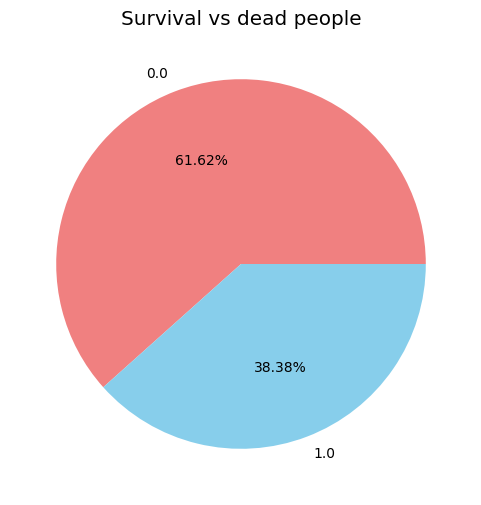

In [12]:
import matplotlib.pyplot as plt
plt.figure( figsize=(15,6) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival vs dead people' )  # 圖標題
plt.ylabel( '' )
plt.show()

### 3.2 相關係數(Correlation)
利用 corr( ) 函數，計算特徵欄位彼此間的相關係數，可作為後續決定篩選哪些特徵欄位，來餵入模型進行訓練。觀察 Survived 欄位與其他特徵欄位的相關係數，發覺彼此間並無明顯的線性關係。

#### 如果在特徵之間存在線性相關性，這會對機器學習模型的表現和解釋性產生一些影響，具體表現在以下幾個方面：

1. 多重共線性問題（Multicollinearity）：

當兩個或多個特徵之間有高度的線性相關性時，會出現多重共線性問題。這會使得模型中的某些係數變得不穩定，且難以解釋。例如，在線性回歸中，若兩個特徵高度相關，模型可能無法準確區分它們的個別影響，導致回歸係數的估計不可靠。
多重共線性會增加估計標準誤差，使得回歸模型中的某些變數可能顯得不顯著，甚至可能對結果造成偏差。

2. 模型的過擬合風險：

如果模型同時利用了線性相關的多個特徵，可能會導致過擬合。過擬合是指模型過度擬合訓練數據，這樣它能在訓練數據上表現良好，但在測試數據或未知數據上表現較差。這是因為模型可能學到了不必要的噪音和冗餘資訊。

3. 維度冗餘：

如果特徵之間存在線性關聯，一些特徵的存在可能是多餘的。這會使得模型的解釋性變差，且可能增加計算成本。這時，進行特徵選擇或降維（如主成分分析PCA）可以幫助消除冗餘的特徵，從而簡化模型並提高性能。

In [13]:
# Survied 與其他欄位間的相關係數
# 選擇數值型列
numeric_df_train = df_train.select_dtypes(include=['number'])

# 計算相關係數
Corr_Matrix = numeric_df_train.corr()

# 提取 'Survived' 與其他欄位的相關係數
Corr = Corr_Matrix.loc['Survived', :].sort_values()[:-1]
Corr = pd.DataFrame({'Survived': Corr})

Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


### 3.3 生存率(Survival Rate)  

接下來，我們分別觀察性別(Sex)、票務艙(Pclass)、登船港口(Embarked)、兄弟姊妹配偶人數(SibSp)、父母子女人數(Parch)與生存率的關係。

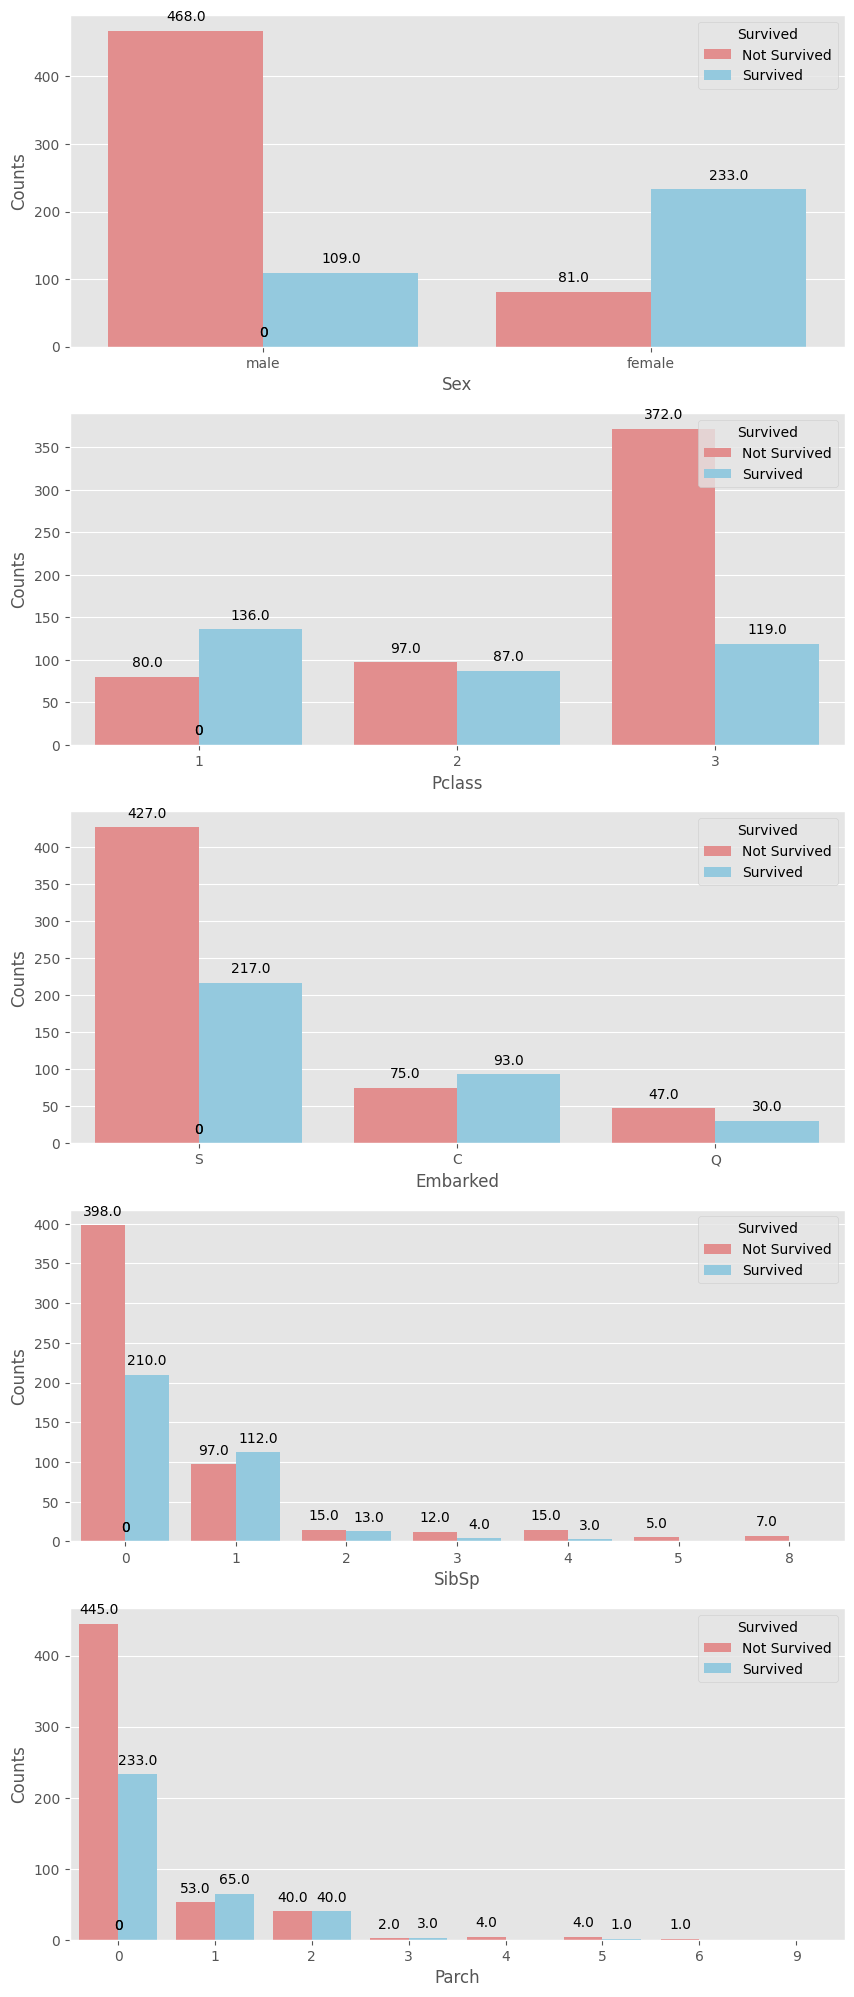

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 將 0.0 替換為 'female'，1.0 替換為 'male'
df_data['Sex'] = df_data['Sex'].replace({0.0: 'female', 1.0: 'male'})

# Sex性別、Pclass票務艙、Embarked登船港口、SibSp兄弟姊妹配偶人數、Parch父母子女人數
selected_cols = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(10, len(selected_cols) * 5))
gs = gridspec.GridSpec(len(selected_cols), 1)

#enumerate() 函數用於將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標，一般用在 for 循環當中。
for i, col in enumerate(selected_cols):
    ax = plt.subplot(gs[i])
    sns.countplot(x=col, hue='Survived', data=df_data, palette=['lightcoral', 'skyblue'], ax=ax)
    ax.set_ylabel('Counts')
    ax.legend(title='Survived', labels=['Not Survived', 'Survived'], loc=1)  # upper right:1 ; upper left:2
    for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [15]:
for col in selected_cols:
    l = ['Survived']
    l.append(col)
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


透過上列的長條圖(Bar Plot)與統計表，我們可得到下列的觀察：
* 女性的生存率明顯高於男性；  
* 票務艙($Pclass$)的生存率大小: Pclass 1 > Pclass 2 > Pclasss 3；
* 登船港口($Embarked$)的生存率以 C 最高；
* 當船上的兄弟姐妹配偶人數($SibSp$)有 1 人同行時，則生存率較高；
* 當船上的父母子女人數($Parch$)為 1~3 人時，有較高的生存率。

## 1205

由於 SibSp 與 Parch 欄位所記錄的人數皆屬於家庭成員，所以我們將兩者相加創造新的特徵欄位稱家庭人數(Family_Size)，並觀察 Family_Size 與生存率的關係

In [16]:
# 創造新的特徵變數：家庭人數(Family_Size)
df_data['Family_Size'] = df_data['SibSp'] + df_data['Parch'] + 1

Survival_Rate = df_data[['Family_Size','Survived']].groupby(by=['Family_Size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Family_Size,Survival Rate(%)
0,1,30.353818
1,2,55.279503
2,3,57.843137
3,4,72.413793
4,5,20.000000
5,6,13.636364
6,7,33.333333
7,8,0.000000
8,11,0.000000


發現當家庭人數為4時的生存率(約 72.4%)明顯高於其他人數。

透過上列 Family_Size 欄位與生存率的關係，我們將 Family_Size 的生存率做級別的區分(3 表示生存率最高、1 為最低)。

In [17]:
df_data[ 'Family_Class' ] = np.nan

df_data.loc[ df_data.Family_Size==0, 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=1) & (df_data.Family_Size<=3), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_Size>=4) & (df_data.Family_Size<=6), 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=7), 'Family_Class' ] = 1

另外，就整體而言，女性乘客的生存率(74%)明顯高於男性(19%)，此時我們想更深入探討，在不同票務艙(Pclass)中的男性及女性，生存率是否也有明顯的差別？

In [18]:
# Sex & Pclass
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Sex,Pclass,Survival Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


我們發現在 Pclass 1 與 Pclass 2 中，男女的生存率差異性更是明顯！！其中，在 Pclass 1 中的女性乘客生存率更是高達約 97%。

我們在用相同的概念，分成不同的生存率級別(3最高、1最小)：

In [19]:
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==1), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==2), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==3), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==1), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==2), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==3), 'Sex_Pclass' ] = 2

## 4. 特徵工程(Feature Engineering)
模型特徵是機器學習 (ML) 在訓練和推論期間用於預測的輸入。ML 模型精度有賴於特徵的精確集合與組合。例如，在推薦音樂播放清單的 ML 應用程式中，特徵可能納入了歌曲評分、先前聽過哪些歌曲以及聽歌時間。建立特徵可能需要大量的工程工作。

特徵工程是一個處理和轉換原始數據以創造對模型訓練更有意義的特徵的過程。

特徵工程涉及從原始資料中擷取和轉換變數，例如價格清單、產品描述和銷量，以便您可以使用特徵進行訓練和預測。工程設計特徵所需的步驟包括資料擷取和清理，然後是特徵建立與儲存。

最主要的目的還是提升模型的預測能力。
### 特徵工程有哪些挑戰
1. 資料擷取

收集資料是組合 ML 所需全部資料的程序。資料收集可能很乏味，因為資料駐留在許多資料來源中，包括筆記型電腦、資料倉儲、雲端、應用程式內部和裝置。尋找各種可連線至不同資料來源的方式可能具有挑戰性。資料量呈指數級增長，因此，需要搜尋大量資料。此外，資料的格式和類型因來源而異。例如，影片資料和表格式資料很難一起使用。

2. 特徵建立

資料標記是識別原始資料 (影像、文字檔案、影片等) 並新增一或多個有意義與資訊性的標籤來提供內容的過程，讓 ML 模型可從中學習。例如，標籤會顯示相片中是否有鳥或汽車，指出一段錄音中會說出哪些字詞，或者 X 光片中是否發現異常情況。對於各種使用案例 (包含電腦視覺、自然語言處理和語音識別) 而言，必須提供資料標記。

3. 特徵儲存

在對資料進行清除和標記後，ML 團隊通常會探索資料以確保其正確，並為 ML 做好準備。長條圖、散佈圖、箱線圖、折線圖和橫條圖等視覺化，都是確認資料正確的實用工具。此外，視覺化還有助於資料科學團隊完成探索性資料分析。此程序使用視覺化來探索模式、發現異常狀況、檢驗假設或檢查假設。探索性資料分析無需正式建模；而資料科學團隊可以使用視覺化來破譯資料。 

Source: https://aws.amazon.com/tw/what-is/feature-engineering/


### 補充 **資料的分類**


---

#### **1. 類別型資料（Categorical Data）**
- **定義**：資料屬於有限的離散類別，這些類別可以是標籤或數值，但無法直接進行數學運算。
- **特性**：
  - **名目型（Nominal Data）**：無法排序的類別，例如顏色（紅、藍、綠）、城市名稱。
  - **次序型（Ordinal Data）**：可排序但無法進行數學運算，例如教育程度（高中、大學、碩士）。
- **處理方法**：
  - 將類別型資料轉換為數值（編碼）以供模型使用，例如：
    - **One-Hot Encoding**：將每個類別轉換為二進制向量。
    - **Label Encoding**：將類別標籤轉換為整數（但需注意避免引入虛假的數值關係）。

---

#### **2. 數值型資料（Numerical Data）**
- **定義**：資料是可以進行數學運算的數值，且通常分為連續或離散兩種。
- **特性**：
  - **連續型（Continuous Data）**：可以取任意值，例如溫度、身高、體重。
  - **離散型（Discrete Data）**：只能取特定值，例如班級人數、產品數量。
- **處理方法**：
  - **標準化（Standardization）**：將數據轉換為均值為0、標準差為1的正態分佈。
  - **正規化（Normalization）**：將數據縮放到指定區間（如0到1）。

---

#### **3. 時間序列資料（Time Series Data）**
- **定義**：數據按時間順序排列，觀測值與時間密切相關。
- **特性**：
  - 包含時間維度。
  - 具有自相關性，即當前數據與歷史數據之間有關聯。
- **處理方法**：
  - **時間分解**：從時間戳提取特徵（年、月、日、季節）。
  - **移動平均**：平滑數據以去除波動。

---

#### **4. 文本資料（Text Data）**
- **定義**：以文字形式表達的非結構化數據。
- **特性**：需要進行預處理（如分詞、向量化）才能用於模型。
- **處理方法**：
  - **詞袋模型（Bag of Words）**：計算每個詞在文檔中的出現次數。
  - **TF-IDF（Term Frequency-Inverse Document Frequency）**：考慮詞的重要性。
  - **嵌入向量（Embeddings）**：如 Word2Vec 或 BERT。




### 補充: 結構化、半結構化、非結構化資料的比較
#### **1. 結構化資料（Structured Data）**
- **定義**：指具有明確組織和格式的數據，通常以行和列的方式儲存，適合存放於關聯式資料庫中。
- **特性**：
  - 資料呈現高度組織化。
  - 使用固定的數據架構，如表格格式（行和列）。
  - 易於查詢與分析，支援 SQL 等語言操作。
- **例子**：
  - 數據庫表格：例如產品資訊（ID、名稱、價格、數量）。
  - 財務記錄：收入與支出表。
- **應用**：
  - 資料分析（如報表生成）。
  - 資料挖掘（如預測分析）。
- **優勢**：
  - 易於管理和分析。
  - 與資料庫管理系統高度兼容。
- **限制**：
  - 僅適用於結構化的數據格式，無法存放更靈活或不規則的數據。

---

#### **2. 半結構化資料（Semi-Structured Data）**
- **定義**：指具有某些結構化特徵，但不完全遵循固定格式的數據。這些數據通常包含標籤（Tags）或標記（Markers）來表示屬性。
- **特性**：
  - 結構不完全固定，但有內部的組織。
  - 可靈活擴展結構，允許不規則或嵌套的數據格式。
  - 無需關聯式資料庫即可儲存。
- **例子**：
  - JSON 或 XML 文件：如 `{ "姓名": "王小明", "年齡": 25 }`。
  - 電子郵件：包含標籤（寄件人、主旨）與不規則的文本內容。
  - 日誌文件：如伺服器日誌、網絡流量記錄。
- **應用**：
  - API 數據交換（JSON 格式的資料傳輸）。
  - 搜尋引擎（如分析網頁資料）。
- **優勢**：
  - 易於存儲非規則數據。
  - 更靈活，能處理動態結構。
- **限制**：
  - 資料的解析與分析較為複雜。
  - 不適合過於混亂或完全無結構的數據。

---

#### **3. 非結構化資料（Unstructured Data）**
- **定義**：指完全無固定格式的數據，通常以文件、媒體或其他形式存在，並且沒有預定義的資料模型。
- **特性**：
  - 缺乏明確的結構或標籤。
  - 分析和處理的難度較高。
  - 數據體積龐大，通常需要大數據技術處理。
- **例子**：
  - 圖片：如 JPEG、PNG。
  - 影片：如 MP4。
  - 文本檔案：如社交媒體內容、新聞文章。
  - 音訊文件：如 MP3。
- **應用**：
  - 自然語言處理（NLP）：處理文本數據。
  - 圖像識別與電腦視覺：分析照片與影片。
  - 聲音識別：處理音訊檔案。
- **優勢**：
  - 適用於更多樣化的資料形式。
  - 能捕捉豐富的資訊內容。
- **限制**：
  - 存儲和分析成本高。
  - 通常需要專門的工具（如 Hadoop 或 TensorFlow）。

---

### **比較表**

| 類型          | 結構化資料            | 半結構化資料         | 非結構化資料         |
|----------------|-----------------------|----------------------|----------------------|
| **結構**       | 高度結構化（行與列）   | 部分結構化（有標籤） | 無結構               |
| **儲存**       | 關聯式資料庫（SQL）   | 文件格式（XML, JSON） | 文件儲存系統（NoSQL） |
| **處理難度**   | 最低                 | 中等                 | 最高                 |
| **例子**       | 銷售數據表格         | 電子郵件、JSON 檔案  | 圖片、影片、音訊     |
| **工具**       | SQL, Tableau         | NoSQL, Elasticsearch | Hadoop, TensorFlow  |

---


### 4.1 字串欄位處理
#### Name (姓名)

首先，我們可先觀察 Name 欄位，發現可以擷取出稱謂(Title)的資訊，來幫助提升模型預測的準確度。一般在處理字串資料時，常用的函數有 split( )、repalce( ) 等來分割或取代字串中的文字，再比較程式語法化的方法可參考正規表示法(Regular Expression)，這裏我們分別練習兩種方法：split( ) 與正規表示法，來擷取出 Name 欄位中的稱謂，產生的結果將僅有一個不同，其他皆完全相同：

split( )：使用空格分割字串，並取出第二個元素，再以逗號分割字串，取出第一個元素。

正規表示法：使用正規表示法，擷取出稱謂的文字，並去除空格。

In [20]:
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [ ]:
# Method 2: 正規表示法(Regular Expression)
import re

# 正規表示法(Regular Expression): [A-Za-z]+ 表示一個或多個英文字母
regex = re.compile( ' ([A-Za-z]+)\.' )

df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

將同樣性別或關係的稱謂合併，避免產生某些稱謂僅有少數乘客，例如：Rev(Reverend)為牧師的尊稱、Countess為伯爵夫人等，影響模型的預測準確度。這裏我們將利用 replace( ) 函數，將上述擷取出的稱謂總歸為五類：Mr、Mrs、Miss、Master、Rare。

In [22]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [23]:
# 刪除原始資料中的 Name 欄位
df_data.drop( 'Name', axis=1, inplace=True )

### 4.2  船票號碼(Ticket)
另外，我們合理假設 Ticket 中，前面英文字母的部份代表房間位於相同的區域中，我們再次利用 split( ) 及 repalce( ) 函數，來擷取 Ticket 字串中前面英文字母的部份文字訊息，作為乘客艙房的位置分區。

In [24]:
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()



array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

unique( ) 函數可用來計算欄位中有多少不同的值，這裏我們計算 Ticket 欄位中不同的英文字母有 9 種，並將其分類為 5 種區域。

In [25]:
# 刪除原始資料中的 Ticket 欄位
df_data.drop( 'Ticket', axis=1, inplace=True )

### 4.3 填補缺漏值(Missing Values)  

針對存有缺漏值的欄位：Embarked、Fare、Cabin 及 Age 進行補值。一般而言，我們常選擇用平均值(Mean)、中位數(Median)或眾數(Mode)等補值，且利用 fillna( ) 函數來執行填補的動作，另外，較為進階的做法是透過機器學習模型進行補值，如：線性迴歸模型(Linear Regression)、決策樹(Decision Tree Regressor)等。   
在補缺漏值前，我們再次查看整體資料的缺漏值分佈情況：

In [26]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


#### 票價(Fare) : 填補整體票價的中位數

In [27]:
df_data['Fare'].fillna( df_data.Fare.median(), inplace=True )

#### 登船港口(Embarked) : 填補次數最多的港口 'S'

In [28]:
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

#### 年齡(Age) :

因為 Age 欄位的缺漏值佔比約有 20% ，不像前面 Fare 及 Embarked 欄位中僅有少數不到 1% 的缺漏值，因此我們所填補缺漏的值可能會影響預測的結果。此時，我們先藉由 Age 搭配 Sex 或 Pclass 欄位，觀察缺漏值分布的情況，檢視缺漏值是否集中發生在某類特別的乘客當中？

In [29]:
# 新增標註 Age 欄位是否為缺漏值的欄位(有缺漏標為0)
df_data['isAge'] = df_data['Age'].isnull().map( lambda x:0 if x==True else 1 )

In [30]:
# 分別觀察 Age 與 Sex、Pclass 的缺漏值分布狀況
display( pd.crosstab( df_data.isAge, df_data.Sex, margins=True ) )
display( pd.crosstab( df_data.isAge, df_data.Pclass, margins=True ) )

Sex,female,male,All
isAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


Pclass,1,2,3,All
isAge,,,,
0,39,16,208,263
1,284,261,501,1046
All,323,277,709,1309


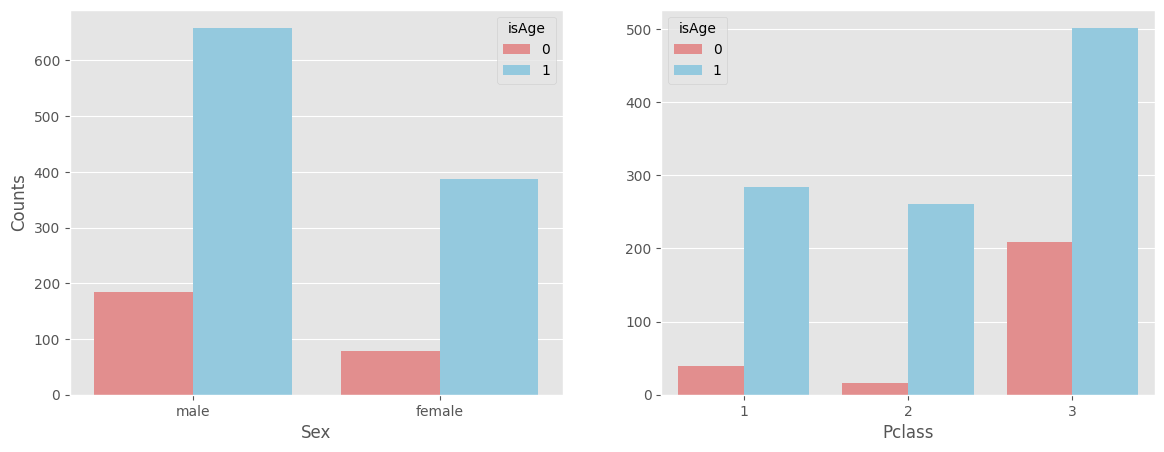

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# plt.suptitle('Age')

plt.subplot(1, 2, 1)
sns.countplot(x='Sex', hue='isAge', data=df_data, palette=['lightcoral', 'skyblue'])
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
sns.countplot(x='Pclass', hue='isAge', data=df_data, palette=['lightcoral', 'skyblue'])
plt.ylabel('')

plt.show()

經觀察上表及圖後可知，Age 欄位的缺漏值明顯分佈在 Pclass 3 中，約佔 29.34%(=208/709)，進一步觀察在 Pclass 1 及 Pclass 2 的乘客中，Age 欄位對於存活率是否有明顯的影響？

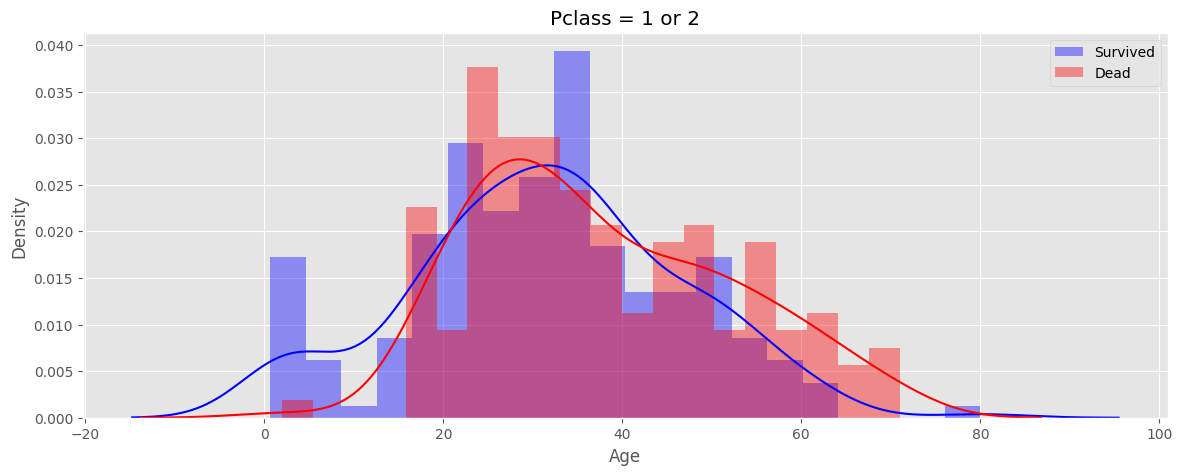

In [34]:
index_S = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)

plt.figure( figsize=(14,5) )
sns.distplot( df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived' )
sns.distplot( df_data.loc[index_D,'Age'], bins=20, color='red', label='Dead' )
plt.title( 'Pclass = 1 or 2' )
plt.legend( )
plt.show( )

從上圖可觀察到，在 Pclass 1 及 Pclass 2 的乘客中，年齡約小於 17 歲的乘客中有明顯較高的生存率，若年齡超過 17 歲則生存率並無明顯的差別，所以我們可大膽假設 Age 欄位與生存率具有關聯性，另外，因為年齡與稱謂(Title)也有相當程度的關聯，因此，我們將先計算每個稱謂的年齡平均值，再用此平均值來填補每個 Title 中所對應 Age 欄位的缺漏值。

In [35]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,47.5


,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.178571


In [36]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位
df_data.drop( 'isAge', axis=1, inplace=True )

填滿 Age 欄位的缺漏值後，我們將年齡特徵再區分成未滿17歲及17歲以上，未滿17歲的乘客標為1，17歲以上的乘客標為0。

In [37]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17
0,1,0.0,3,male,22.000000,1,0,7.2500,NaN,S,2,3.0,2.0,Mr,A5,0
1,2,1.0,1,female,38.000000,1,0,71.2833,C85,C,2,3.0,2.0,Mrs,PC,0
2,3,1.0,3,female,26.000000,0,0,7.9250,NaN,S,1,3.0,3.0,Miss,STONO2,0
3,4,1.0,1,female,35.000000,1,0,53.1000,C123,S,2,3.0,2.0,Mrs,X,0
4,5,0.0,3,male,35.000000,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,A5,0
1305,1306,NaN,1,female,39.000000,0,0,108.9000,C105,C,1,3.0,2.0,Rare,PC,0
1306,1307,NaN,3,male,38.500000,0,0,7.2500,NaN,S,1,3.0,2.0,Mr,SOTONOQ,0
1307,1308,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0


### 4.4 船艙號碼(Cabin) :

因爲整體 Cabin 欄位約有 77% 的缺漏值，我們在觀察 Cabin 欄位中的資料類別後，僅取出頭一個英文字母作為分類的標籤，其他缺漏的欄位以 NoCabin 表示。

In [38]:
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [39]:
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

最後，在完成上述缺漏值的填補後，我們再次檢查是否還有缺漏值尚未填補到。

In [40]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)


### 4.5 離群值(Outlier)   

因為離群值會明顯影響非樹狀模型的預測結果，例如：線性迴歸(Linear Regression)模型，因此，針對連續型的數值欄位，我們還需再檢視其資料的分布情況，透過觀察直方圖(Histogram)或盒鬚圖(Box Plot)，可用來判斷欄位是否有離群值。   

#### 乘客票價(Fare) :   

首先，我們先觀察 Fare 欄位的直方圖(Histogram)及盒鬚圖(Box Plot)資料分布狀況：  

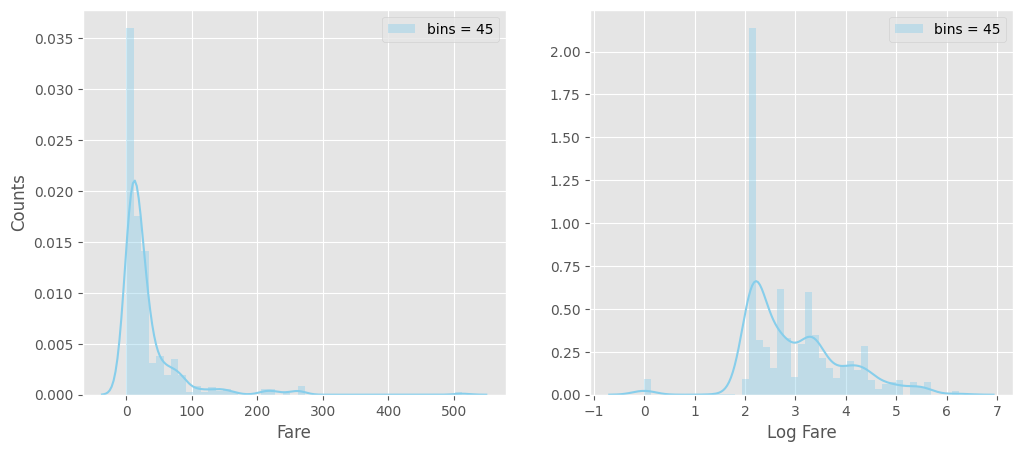

In [41]:
# 對 Fare 欄位取對數
df_data['LogFare'] = np.log1p( df_data.Fare )

# 直方圖(Histogram)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.distplot( df_data.Fare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Fare' )
plt.ylabel( 'Counts' )
plt.legend( )

plt.subplot( 1,2,2 )
sns.distplot( df_data.LogFare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Log Fare' )
plt.ylabel( '' )
plt.legend( )

plt.show()

#### 補充: 幹嘛取log?對數變換(Log Transformation)的原因及意義
對數變換（log transformation）是一種常見的數據處理技術，主要用於處理數據的分佈性質，使其更適合於建模或可視化。以下是對 `Fare` 欄位取對數的原因及其意義：

---

**1. 處理數據的偏態分佈（Skewness）**
- **問題**：`Fare`（票價）通常是正偏分佈（右偏分佈），即有少量極高的票價值偏離主要分佈範圍，這會對模型的效果產生影響。
- **解決**：通過對數變換，可以將偏態分佈轉化為更接近正態分佈的形態，這對於許多統計模型（如線性回歸）更為適用。

---

**2. 減少極端值的影響**
- **問題**：極端值（outliers）在原始比例下的影響非常顯著，可能會誤導模型。
- **解決**：取對數會壓縮數據範圍，特別是對於極端高值，它們在變換後對模型的影響減弱，從而提高穩健性。

---

**3. 改善可視化效果**
- **問題**：原始數據的分佈可能呈現高度的不對稱性或集中於某一區間，難以在直方圖或其他圖表中直觀地呈現。
- **解決**：通過對數變換，分佈拉開，細節更加明顯，視覺化效果更好。

---

**4. 符合模型假設**
- **問題**：某些機器學習或統計模型（如線性回歸）假設數據是正態分佈或線性關係，但原始票價數據可能不符合這些假設。
- **解決**：對數變換後，數據更可能滿足模型的假設，使模型訓練更加有效。

---

**公式解釋**
對數變換採用了 `np.log1p`：
- `np.log1p(x)` 是對 \( x + 1 \) 取自然對數，避免出現 \( \log(0) \) 的問題（當票價為 0 時）。
- \( \text{LogFare} = \log(Fare + 1) \)。

---

**變換前後的效果**
在圖表中可以看到：
- **左圖**（原始 `Fare`）：數據偏態分佈明顯，多數數據集中於低價區域，高價形成長尾。
- **右圖**（對數變換後的 `LogFare`）：分佈更趨於對稱，呈現鐘型形態，適合進一步分析。



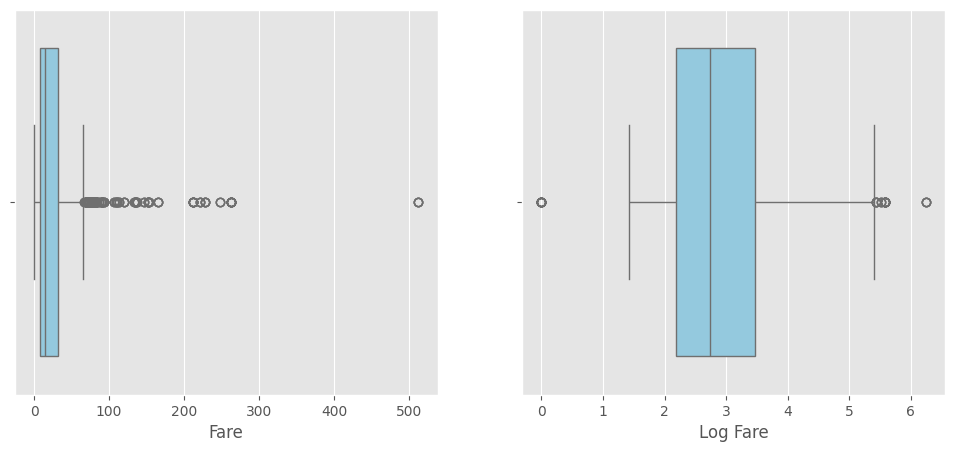

In [42]:
# 盒鬚圖(Box Plot)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.boxplot( df_data.Fare, orient='h', color='skyblue' )
plt.xlabel( 'Fare' )

plt.subplot( 1,2,2 )
sns.boxplot( df_data.LogFare, orient='h', color='skyblue' )
plt.xlabel( 'Log Fare' )

plt.show()

盒鬚圖（Boxplot）是一種統計圖形，用於直觀地展示數據的分佈情況，包括數據的集中趨勢、變異程度以及可能的異常值（outliers）。以下是盒鬚圖的解釋與分析方法：

**盒鬚圖的組成**
1. **中位數（Median）**：
   - 盒子內的一條水平線，表示數據的中位數（第50百分位數，Q2）。
   - 它反映了數據的中心位置。

2. **第一四分位數（Q1）**：
   - 盒子的底部邊界，表示數據的第25百分位數。
   - \( Q1 \) 是下四分位數，表示數據中25%數值比它小。

3. **第三四分位數（Q3）**：
   - 盒子的頂部邊界，表示數據的第75百分位數。
   - \( Q3 \) 是上四分位數，表示數據中75%數值比它小。

4. **四分位距（IQR）**：
   - 四分位距 = \( Q3 - Q1 \)，表示數據分佈的範圍。
   - 盒子的高度代表 IQR，是數據變異程度的一個指標。

5. **鬚（Whiskers）**：
   - 盒子上下延伸的直線，表示數據範圍內的主要分佈區域。
   - 通常定義為 \( Q1 - 1.5 \times IQR \) 到 \( Q3 + 1.5 \times IQR \) 之間的數據範圍。

6. **異常值（Outliers）**：
   - 鬚範圍之外的數據點，用小圓點或星號表示。
   - 表示與主要數據分佈不一致的極端值。

---



從上面直方圖及盒鬚圖可知，初步判斷 Fare 欄位可能存有離群值( i.e., 大於 Q3+1.5$\times$IQR )。計算 Fare 欄位的四分位數(Quartile)，且以四分位數對 Fare 欄位進行分組，觀察生存率是否會因票價組別的高低有所差異？藉此判斷票價大於 Q3+1.5$\times$IQR 是否可視為離群值。

In [43]:
# 計算 Fare 欄位各個百分位數(Percentile)
P_all = [ np.percentile( df_data.Fare, q=i ) for i in np.arange(0,101) ]
Pth_Percentile = pd.DataFrame( { 'Q':list(range(101)), 'Value':P_all } )

# The first、second and third quartile(i,e., the 25th、50th and 75th Percentile)
Q1 = Pth_Percentile.iloc[ 25, 1 ]
Q2 = Pth_Percentile.iloc[ 50, 1 ]
Q3 = Pth_Percentile.iloc[ 75, 1 ]
IQR = Q3 - Q1

print( f'Q1 = {Q1}' )
print( f'Q2 = {Q2} = Median' )
print( f'Q3 = {Q3}' )
print( f'Maximum = {df_data.Fare.max()}')
print( f'IQR = Q3 - Q1 = {IQR}' )
print( f'Q3 + 1.5IQR = {Q3+1.5*IQR}' )

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )

# 計算每個分組中的資料筆數
Group_Counts = df_data[ 'Fare_Group' ].value_counts().reset_index()
Group_Counts.columns = [ 'Fare_Group', 'Counts' ]
Group_Counts.sort_values( by='Fare_Group' )

Q1 = 7.8958
Q2 = 14.4542 = Median
Q3 = 31.275
Maximum = 512.3292
IQR = Q3 - Q1 = 23.379199999999997
Q3 + 1.5IQR = 66.34379999999999


,Fare_Group,Counts
2,"(0.0, 7.896]",320
1,"(7.896, 14.454]",321
0,"(14.454, 31.275]",328
4,"(31.275, 66.344]",152
3,"(66.344, 512.329]",171


再次藉由長條圖及盒鬚圖，觀察不同的票價組別，彼此間生存率的差異性。

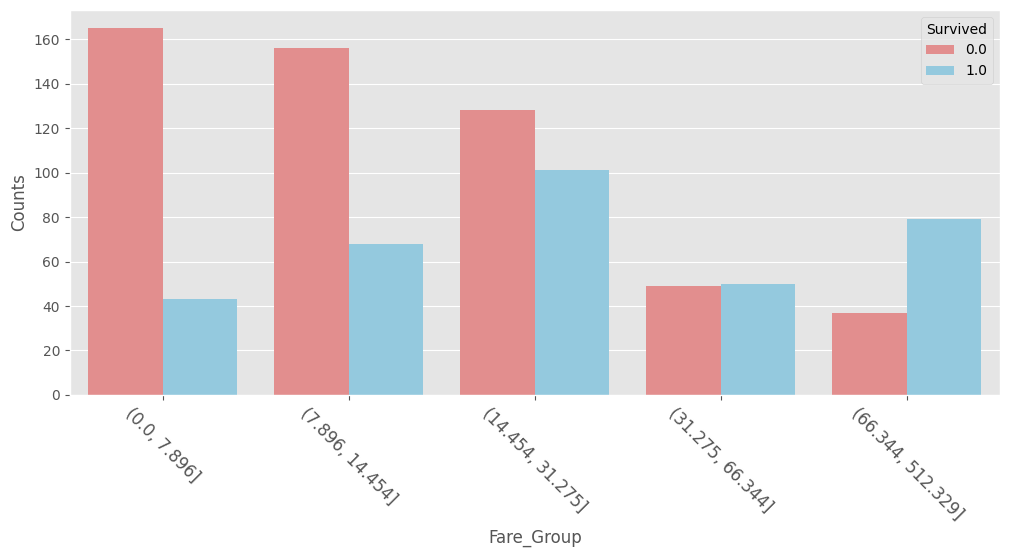

In [45]:


plt.figure(figsize=(12, 5))
sns.countplot(x='Fare_Group', hue='Survived', data=df_data, palette=['lightcoral', 'skyblue'])
plt.ylabel('Counts')
plt.xticks(rotation=-45, fontsize=12)
plt.show()

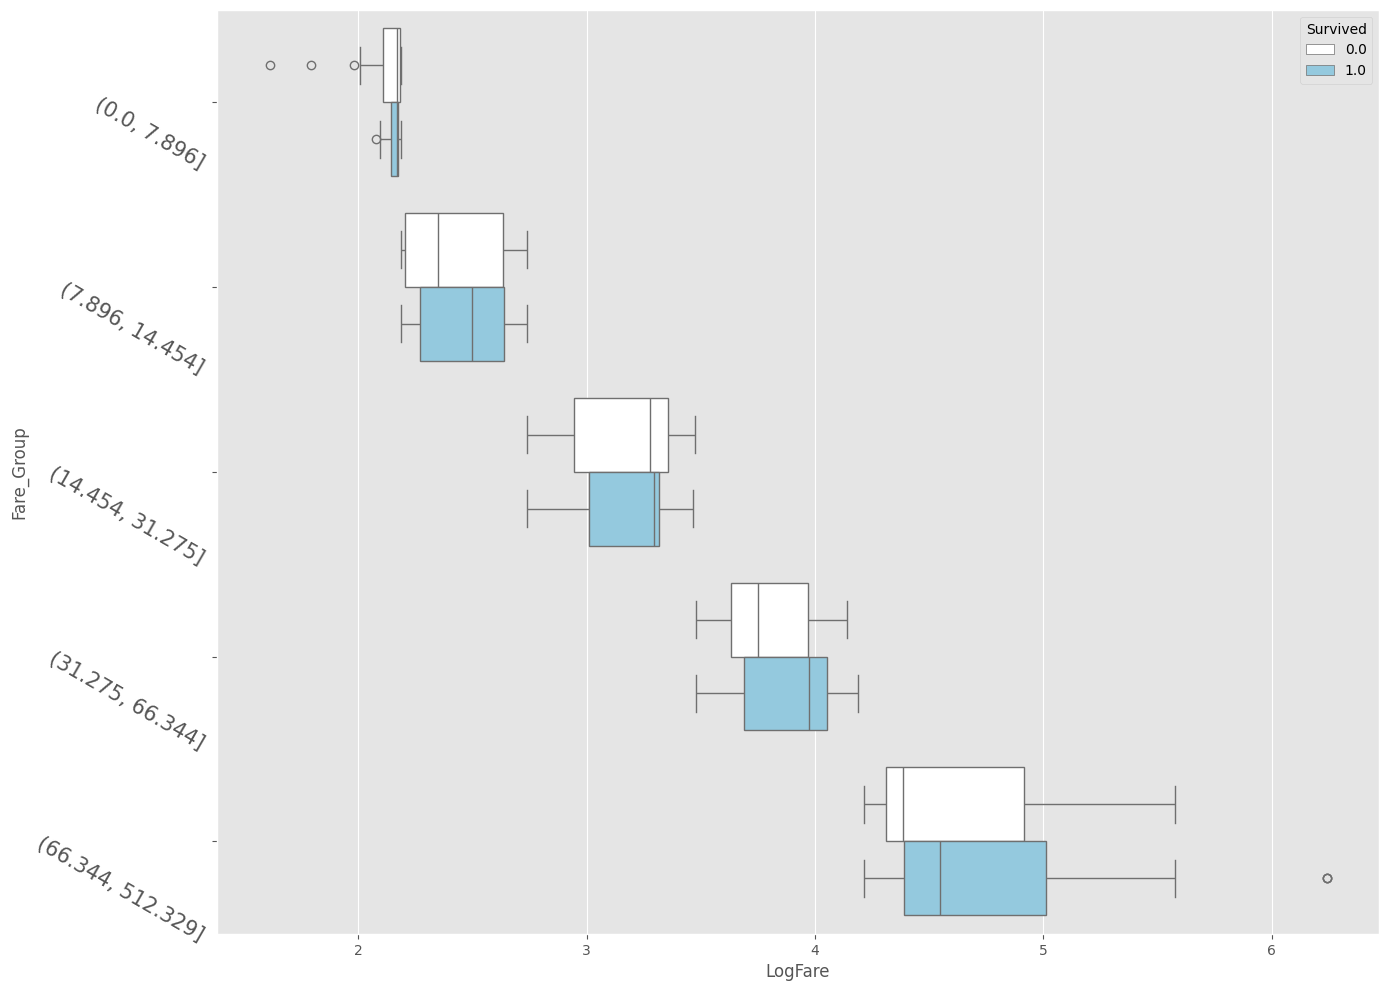

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 12))
sns.boxplot(x='LogFare', y='Fare_Group', data=df_data, hue='Survived', orient='h', palette=['white', 'skyblue'])
plt.yticks(rotation=-30, fontsize=15)
plt.show()

從上圖可明顯觀察出，票價組別越高生存率相對越大，且每一票價組別中，生還者的票價中位數皆高於罹難者的票價中位數；所以，我們可大膽推測 Fare 與生存率有相關性，Fare 越高生存機率越大，且對 Fare 欄位僅做對數轉換並不做離群值的處理。

In [48]:
# 刪除 Fare_Group 欄位
df_data.drop( ['Fare','Fare_Group'], axis=1, inplace=True )

### 4.6 獨熱編碼(OneHot Encoding)、標籤編碼(Label Encoding)  

對於定性且無序的特徵欄位，例如：性別、顏色、國家別等，我們可利用 get_dummies( ) 函數執行獨熱編碼，將其轉換成定量資料，這裏我們對 Embarked 欄位做獨熱編碼；另外，因為女性的生存率明顯高於男性，故我們對 Sex 欄位做標籤編碼。

### 補充 


#### **1. 獨熱編碼（OneHot Encoding）**

**定義**
- 將類別型數據轉換為二進制向量表示，每個類別由一個唯一的二進制向量表示。
- 每個類別都有一個單獨的位置標記為 1，其他位置為 0。

**使用方式**
假設有一個類別型特徵 **Color**，包含以下三個值：
- Red
- Green
- Blue

經過獨熱編碼後：
| Color | Red | Green | Blue |
|-------|-----|-------|------|
| Red   |  1  |   0   |   0  |
| Green |  0  |   1   |   0  |
| Blue  |  0  |   0   |   1  |

**優點**
1. 不引入數值大小的虛假順序關係（適用於無序類別型數據）。
2. 提供明確的二進制表示，模型更容易理解類別之間的獨立性。

**缺點**
1. 當類別數量較多時，會導致維度急劇增高（稱為「維度災難」）。
2. 對於稀疏矩陣計算，效率較低。

**適用場景**
- 無序類別型特徵（如顏色、地點名稱）。
- 避免模型誤解類別之間的數值大小關係。

---

#### **2. 標籤編碼（Label Encoding）**

**定義**
- 將每個類別分配一個整數標籤，按類別的數量從 0 開始依次編碼。

**使用方式**
**Color** 特徵為例：
- Red → 0
- Green → 1
- Blue → 2

經過標籤編碼後：
| Color | Encoded |
|-------|---------|
| Red   |    0    |
| Green |    1    |
| Blue  |    2    |

**優點**
1. 簡單易用，不會增加數據的維度。
2. 適用於樹模型（如決策樹、隨機森林等），這類模型對數值大小不敏感。

**缺點**
1. 可能引入數值大小的虛假關係，例如模型可能認為 `Blue(2)` 比 `Red(0)` 更大。
2. 對於線性模型，可能影響模型的準確性，因為類別之間的「距離」無實際意義。

**適用場景**
- 有序類別特徵（如等級：低、中、高）。
- 使用不敏感於數值大小的模型（如樹模型）。


In [49]:
# OneHot Encoding
OneHot_Embarked = pd.get_dummies( df_data.Embarked, prefix='Embarked' )

# 合併 Embarked 編碼後的欄位
df_data = pd.concat( [ df_data, OneHot_Embarked ], axis=1 )
df_data.drop( 'Embarked', axis=1, inplace=True )

In [50]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

## 5. 模型的訓練集(Train)與測試集(Test)

在完成前述的資料分析及特徵工程後，我們就快可以把資料餵入模型進行訓練了！在此之前的最後一個注意步驟，就是需確認每個欄位皆為數值型態，且將資料分割回訓練集(train)與測試集(test)。所以，此時我們先檢視特徵工程後的資料，觀察是否還有需要處理的欄位：

In [51]:
# 檢視特徵工程後的資料
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 18)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,NoCabin,2,3.0,2.0,Mr,A5,0,2.110213,False,False,True
1,2,1.0,1,1,38.0,1,0,C,2,3.0,2.0,Mrs,PC,0,4.280593,True,False,False
2,3,1.0,3,1,26.0,0,0,NoCabin,1,3.0,3.0,Miss,STONO2,0,2.188856,False,False,True
3,4,1.0,1,1,35.0,1,0,C,2,3.0,2.0,Mrs,X,0,3.990834,False,False,True
4,5,0.0,3,0,35.0,0,0,NoCabin,1,3.0,2.0,Mr,X,0,2.202765,False,False,True


### 5.1 類別型態欄位轉為整數  

檢視後發現，因為我們之前有處理過字串欄位，所以資料中還存有 4 欄類別型態的欄位：Cabin、Embarked、Title、Ticket_info，因此，我們也需要將它們轉換成數值型態欄位：

In [52]:
for col in ['Title','Ticket_info','Cabin']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7,2,3.0,2.0,2,2,0,2.110213,False,False,True
1,2,1.0,1,1,38.0,1,0,2,2,3.0,2.0,3,14,0,4.280593,True,False,False
2,3,1.0,3,1,26.0,0,0,7,1,3.0,3.0,1,31,0,2.188856,False,False,True
3,4,1.0,1,1,35.0,1,0,2,2,3.0,2.0,3,36,0,3.990834,False,False,True
4,5,0.0,3,0,35.0,0,0,7,1,3.0,2.0,2,36,0,2.202765,False,False,True


### 5.2 產生訓練集(Train)與測試集(Test)   

最後，我們將整體資料分割回訓練集與測試集兩部份，訓練集用來餵入模型進行訓練，測試集則為模型最終要預測的結果，此外，在分割產出資料後，我們刪除與生存率無毫關聯性的欄位 PassengerId。

In [53]:
# 產生訓練集和測試集
Train = df_data[ pd.notnull(df_data.Survived) ]
Test = df_data[ pd.isnull(df_data.Survived) ]

# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
Train.drop( ['PassengerId'], axis=1, inplace=True )
Test.drop( ['PassengerId','Survived'], axis=1, inplace=True )

# 將測試集中的標籤欄位 Survived 單獨拆出
Y_Train = Train.Survived
X_Train = Train.drop( ['Survived'], axis=1 )

print( f'Shape of X_Train = {X_Train.shape}' )
print( f'Shape of Y_Train = {Y_Train.shape}' )
print( f'Shape of Test = {Test.shape}' )

Shape of X_Train = (891, 16)
Shape of Y_Train = (891,)
Shape of Test = (418, 16)


### 5.3 特徵重要性(Feature Importance)

我們使用最基本的樹狀模型 - 決策樹(Decision Tree)，來評估特徵欄位對於標籤欄位(Survived)的重要性，目的是幫助我們篩選較具關鍵性的特徵欄位，提升模型的預測能力。評估特徵重要性的方法並非僅侷限於決策樹，另外其他常見的手法有：相關係數(Correlation)、Lasso等。

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


# 建立決策樹模型
DTC = RandomForestClassifier( )
# 自變數、應變數進行擬合
DTC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True )
Feature_Rank

,Feature_Name,Importance
2,Age,0.191205
12,LogFare,0.189858
1,Sex,0.155848
9,Title,0.086555
8,Sex_Pclass,0.065075
5,Cabin,0.061987
0,Pclass,0.060417
6,Family_Size,0.047264
10,Ticket_info,0.037298
3,SibSp,0.030301


### 5.4 建立模型  

在完成評估特徵重要性後，我們選擇使用隨機森林(Random Forest)來預測資料。由於在森林中每一棵樹的生成方法為拔靴法(Boostrap)，表示每一棵樹並不會用到所有的訓練集資料來生成，而未使用的樣本稱為袋外樣本(Out of Bag Sample)，其可用來評估預測的準確度，每一顆樹皆以這種方式生成，最後對所有樹的準確度取平均值，這便是隨機森林的特性。 

In [55]:
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。

RFC = RandomForestClassifier( n_estimators = 1000,
                              min_samples_split = 20,
                              min_samples_leaf = 1,
                              oob_score = True,
                              random_state = 1,
                              n_jobs = -1 )

### 5.5 訓練模型

餵入訓練集資料(X_Train,Y_Train)訓練隨機森林(Random Forest)模型。一般而言，為了衡量模型的預測能力，在訓練模型之前，我們還會從訓練集中抽取出一小部份作為驗證集(Validation)，用來評估模型的準確度，而剩下沒被抽取到的資料則用來訓練模型，另外，為避免只參考某一特定的抽樣驗證結果，導致模型產生偏差，我們會藉由交叉驗證(Cross Validation)，來評估模型的準確度是否能達到我們要求的水準。   
因為隨機森林可藉由前述所提的袋外樣本評估準確度，因此這裏我們便不需進行交叉驗證；然而，我們還想知道特徵欄位的多寡對於模型準確度的影響，所以，先把所有的欄位餵入模型進行訓練：  

In [56]:
# 訓練模型
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_) )

oob_score = 0.828283


### 補充
**1. 決策樹**
**場景**：你想決定今天是否要出門運動。

決策樹就像一連串的「如果……那麼……」的決策過程。例如：

1. **第一步：天氣條件**
   - 如果是 **晴天**，繼續看其他條件。
   - 如果是 **下雨**，直接不出門。

2. **第二步：溫度**
   - 如果溫度 **舒適（20°C - 30°C）**，再看時間。
   - 如果溫度 **過熱或過冷**，不出門。

3. **第三步：時間**
   - 如果是 **早上或下午**，決定出門運動。
   - 如果是 **晚上太晚**，不出門。

最後，這棵決策樹的結論可能是：
- 如果天氣晴、溫度舒適、時間合適 → 出門運動。
- 否則 → 不出門。

**重點**：
- 決策樹是一條單一的路徑，適合快速、直接的決策。
- 缺點是如果某個條件不合理，可能會導致錯誤結論。

---

### **2. 隨機森林**
**場景**：你不僅想依據天氣條件決定，還想多參考家人或朋友的意見。

隨機森林就像是「集思廣益」。你找了多位朋友來幫你決定：
1. **朋友A** 的決策邏輯：
   - 主要看天氣，晴天才建議出門。
2. **朋友B** 的決策邏輯：
   - 更關心溫度，只有溫度舒適才建議出門。
3. **朋友C** 的決策邏輯：
   - 主要看時間，早上或下午才建議出門。
4. **其他朋友**：
   - 每人根據自己的經驗提出建議。

最後，當所有人給出建議後：
- 如果大多數朋友說「出門」 → 你選擇出門。
- 如果大多數朋友說「不出門」 → 你選擇不出門。

**重點**：
- 隨機森林是很多棵決策樹的集合，最終結果由多數決產生。
- 每棵樹只看部分條件（特徵），避免過度依賴某一個條件。

---

### **兩者的比較**
| 特性                | 決策樹                          | 隨機森林                      |
|---------------------|---------------------------------|------------------------------|
| **場景說明**         | 根據一條決策路徑快速判斷           | 集合多條決策路徑，綜合考慮所有因素 |
| **適合情況**         | 情況簡單，邏輯明確                 | 情況複雜，需要穩定且準確的結果     |
| **穩定性**           | 可能因單一條件過度偏向一個結果       | 集合多個條件，結果更穩定          |

---

### **實際應用的範例**
假設我們用數據來解釋：

**數據情境**：你有一個數據集，記錄了多次運動情況，包括 `天氣`、`溫度`、`時間`，以及是否最終出門 (`出門 = 1` 或 `不出門 = 0`)。

#### **決策樹模型的工作方式**
- 模型只建立一棵樹，例如：
  - 如果天氣是晴天且溫度舒適，則出門。
  - 如果天氣是下雨，則不出門。
- 模型可能對某個特徵（如天氣）過度依賴，容易過擬合。

#### **隨機森林模型的工作方式**
- 隨機森林會建立多棵樹，每棵樹使用不同的數據子集或特徵：
  - 第一棵樹可能認為「天氣晴是關鍵」。
  - 第二棵樹可能認為「溫度舒適最重要」。
  - 第三棵樹可能更在乎「時間」。
- 最終，所有樹的結果進行投票，決定是否出門，結果更穩定。

---

### **結論**
- **決策樹**：簡單直接，但容易過於依賴單一條件。
- **隨機森林**：集成多棵樹，結果更準確且穩健，但計算成本更高。


In [57]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 )

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Age','Sex','LogFare','Title','Pclass','Sex_Pclass']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Age', 'Sex', 'LogFare', 'Title', 'Pclass', 'Sex_Pclass']
oob_score = 0.843996


只篩選部份特徵欄位所訓練出的模型準確率約 84.4%，略高於所有特徵欄位所訓練出的模型，從這我們可得到一個寶貴的經驗，就是適當的挑選出關鍵性的特徵欄位進行訓練，對於模型的準確度將會有所提升。

### 5.6 測試集預測

In [58]:
# 預測測試集資料
Test_pred = RFC_2.predict( Test[SelectedFeatures] )

# 檢視預測罹難或生還的機率
#print( RFC_2.predict_proba(Test[SelectedFeatures]) )

# 提交檔案
submit['Survived'] = Test_pred.astype(int)
submit.to_csv( 'Titanic_RandomForest.csv', index=False )
print( f'預測結果：' )
submit

預測結果：


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
